# Nowcasting

In [3]:
# !pip3 install numpy pandas matplotlib statsmodels scipy scikit-learn openpyxl
# !pip3 freeze > requirements.txt

## Packages and Setting

In [1]:
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import ElasticNet, Ridge, Lasso
# from ExtendedDynamicFactor import ExtendedDynamicFactor, OptimizeExtendedDynamicFactor
import dynamicfactoranalysis.dynamicfactoranalysis as dfa
from NowcastingPipeline import NowcastingPH

%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

## Dynamic Factor Model

In [2]:
class NowcastingDFM(NowcastingPH):
    def fit_model(self, vintage, window, DFM_order, optimize_order, **kwargs):
        df, target_scaler, econ_scaler = self.load_data(vintage, window=window, **kwargs)
        factor_order, error_order, k_factors, factor_lag = DFM_order
        df = df.dropna(thresh = k_factors * (1 + factor_lag))
        if optimize_order:
            model_ = dfa.DynamicFactorModelOptimizer(
                endog=df, k_factors_max=k_factors, factor_lag_max=factor_lag, factor_order_max=factor_order, 
                error_order_max=error_order, verbose=True, **kwargs).fit(**kwargs)
        else:
            model_ = dfa.DynamicFactorModel(
                endog=df, k_factors=k_factors, factor_lag=factor_lag, factor_order=factor_order, 
                error_order=error_order, **kwargs)
            
        model = model_.fit(disp=False, maxiter=1000, method='powell', ftol=1e-5, **kwargs)
        DFM_order = (model_.factor_order, model_.error_order, model_.k_factors, model_.factor_lag)
        self.prefix = 'DFM_Opt' if optimize_order else f'DFM{DFM_order}'    # Override class name
        
        nowcasts = model.predict(start=f'{vintage.year}Q1', end=f'{vintage.year}Q4')[['target']]
        nowcasts = list(target_scaler.inverse_transform(nowcasts[['target']]).flatten())
        model_desc = f'DFM{DFM_order}'

        return nowcasts, model_desc

Running NowcastingDFM
Vintage: 2017-01-31 	 DFM(0, 0, 1, 0)
Vintage: 2017-02-28 	 Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
Vintage: 2017-03-31 	 DFM(0, 0, 1, 0)
Vintage: 2017-04-30 	 DFM(0, 0, 1, 0)
Vintage: 2017-05-31 	 DFM(0, 0, 1, 0)
Vintage: 2017-06-30 	 DFM(0, 0, 1, 0)
Vintage: 2017-07-31 	 DFM(0, 0, 1, 0)
Vintage: 2017-08-31 	 DFM(0, 0, 1, 0)
Vintage: 2017-09-30 	 DFM(0, 0, 1, 0)
Vintage: 2017-10-31 	 DFM(0, 0, 1, 0)
Vintage: 2017-11-30 	 DFM(0, 0, 1, 0)
Vintage: 2017-12-31 	 DFM(0, 0, 1, 0)
Vintage: 2018-01-31 	 DFM(0, 0, 1, 0)
Vintage: 2018-02-28 	 DFM(0, 0, 1, 0)
Vintage: 2018-03-31 	 DFM(0, 0, 1, 0)
Vintage: 2018-04-30 	 DFM(0, 0, 1, 0)
Vintage: 2018-05-31 	 DFM(0, 0, 1, 0)
Vintage: 2018-06-30 	 DFM(0, 0, 1, 0)
Vintage: 2018-07-31 	 DFM(0, 0, 1, 0)
Vintage: 2018-08-31 	 DFM(0, 0, 1, 0)
Vintage: 2018-09-30 	 DFM(0, 0, 1, 0)
Vintage: 2018-10-31 	 DFM(0, 0, 1, 0)
Vintage: 2018-11-30 	 DFM(0, 0, 1, 0)
Vintage: 2018-12-31 	 D

,date,Model,Nowcast_A,Actual_A,Difference_A,Overall_RMSE_A,Month_RMSE_A,Quarter_RMSE_A,Year_RMSE_A,Period_RMSE_A,Nowcast_Q,Actual_Q,Difference_Q,Overall_RMSE_Q,Month_RMSE_Q,Quarter_RMSE_Q,Period_RMSE_Q,ForecastQ1,ForecastQ2,ForecastQ3,ForecastQ4
0,2017-01-31,"DFM(0, 0, 1, 0)",6.384634,6.930988,-0.546355,4.630987,6.596395,3.926596,0.408863,0.269867,6.384634,6.374133,0.010501,6.969249,5.556907,0.010501,0.478376,6.384634,6.384634,6.384634,6.384634
1,2017-02-28,No model,NaN,6.930988,NaN,4.630987,7.225600,5.089129,0.408863,0.269867,NaN,6.374133,NaN,6.969249,7.990295,0.010501,0.478376,NaN,NaN,NaN,NaN
2,2017-03-31,"DFM(0, 0, 1, 0)",6.384634,6.930988,-0.546355,4.630987,6.598241,4.810474,0.408863,0.269867,6.384634,6.374133,0.010501,6.969249,7.177952,0.010501,0.478376,6.384634,6.384634,6.384634,6.384634
3,2017-04-30,"DFM(0, 0, 1, 0)",6.381922,6.930988,-0.549066,4.630987,1.700234,3.926596,0.408863,0.269867,6.384272,7.177099,-0.792828,6.969249,5.556907,0.792828,0.478376,6.384272,6.384272,6.384272,6.384272
4,2017-05-31,"DFM(0, 0, 1, 0)",6.381922,6.930988,-0.549066,4.630987,6.758249,5.089129,0.408863,0.269867,6.384272,7.177099,-0.792828,6.969249,7.990295,0.792828,0.478376,6.384272,6.384272,6.384272,6.384272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022-08-31,"DFM(0, 0, 1, 0)",6.425688,7.599235,-1.173547,4.630987,3.316977,5.089129,1.659183,6.496813,5.154432,7.635937,-2.481505,6.969249,7.990295,2.082205,9.773988,5.154432,5.154432,5.154432,5.154432
68,2022-09-30,"DFM(0, 0, 1, 0)",6.425688,7.599235,-1.173547,4.630987,3.316979,4.810474,1.659183,6.496813,5.154432,7.635937,-2.481505,6.969249,7.177952,2.082205,9.773988,5.154432,5.154432,5.154432,5.154432
69,2022-10-31,"DFM(0, 0, 1, 0)",7.031765,7.599235,-0.567471,4.630987,1.546668,3.926596,1.659183,6.496813,5.203089,7.225544,-2.022455,6.969249,5.556907,2.022455,9.773988,5.203089,5.203089,5.203089,5.203089
70,2022-11-30,"DFM(0, 0, 1, 0)",7.031765,7.599235,-0.567471,4.630987,1.546668,5.089129,1.659183,6.496813,5.203089,7.225544,-2.022455,6.969249,7.990295,2.022455,9.773988,5.203089,5.203089,5.203089,5.203089


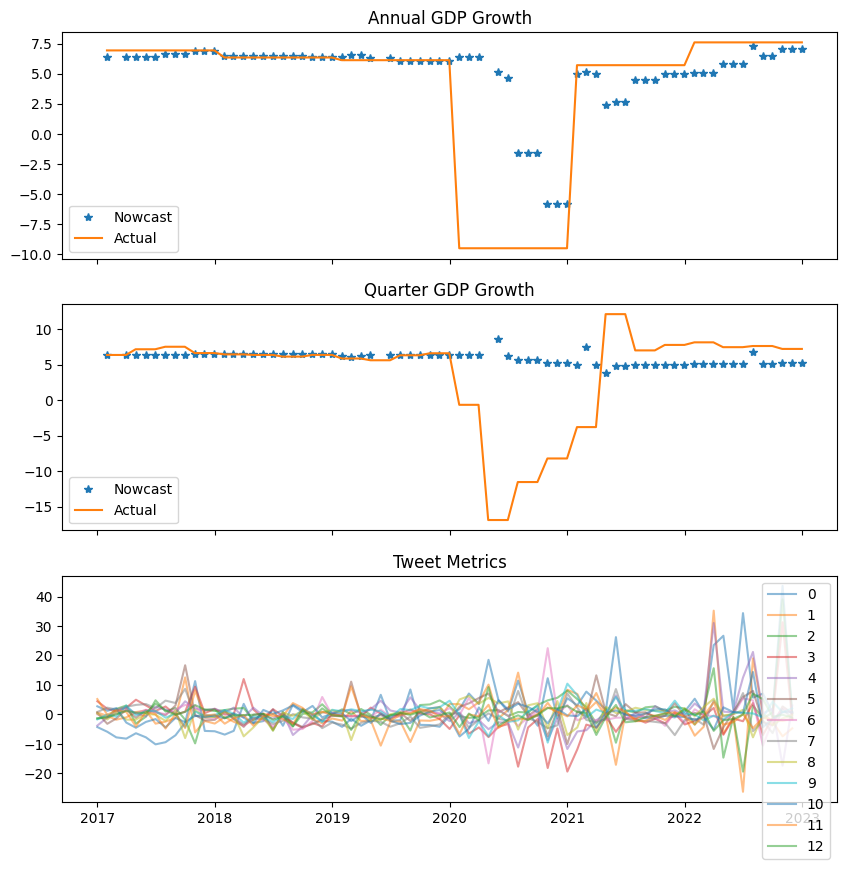

In [3]:
target = 'GDP'
kmpair = {}
window = 25
model = NowcastingDFM(DFM_order=(3,0,2,2), target=target, optimize_order=True, kmpair=kmpair, n_components=0.85, enforce_stationarity=True) # DFM_order = factor_order, error_order, k_factors, factor_lag
summary = model.run(window=window, save_aggregate=True, with_econ=False, with_tweets=True)
# summary = pd.read_csv('Results/DFM(1, 0, 1, 0)_W25_TE_n95_summary.csv', parse_dates=['date'])
tweets = model.load_tweets('2023-01-01', window=window+72, kmpair=kmpair).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend()
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## Elastic Net

In [ ]:
class NowcastingML(NowcastingPH):
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.Q{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.Q{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        df = df.loc[:, ~df.T.duplicated(keep='first')]

        return df

    def fit_model(self, vintage, window, lag_order, **kwargs):
        df, target_scaler, econ_scaler = self.load_data(vintage, window=window, **kwargs)
        df = self.lag_data(df, lag_order)

        X_test = df.loc[vintage + relativedelta(month=3) :, df.columns.drop('target')]
        df_train = df.loc[: vintage - relativedelta(months=3), :].dropna()
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']
        
        model = ElasticNet()
        model.fit(X_train, y_train)
        self.prefix = f'ENet{lag_order}'    # Override class name

        nowcasts = [(model.predict(X_test_.to_frame().T)[0] if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        nowcasts = list(target_scaler.inverse_transform(np.array(nowcasts).reshape(-1,1)).flatten())
        model_desc = f'ENet{lag_order}'

        return nowcasts, model_desc

In [ ]:
model = NowcastingML(lag_order=(0,0,0), with_econ=False) # lag_order = target_lag, tweet_lag, econ_lag
summary = model.run(window=25, save_aggregate=False)
# summary = pd.read_csv('Results/ENet(2, 1, 0)_W25_TE_summary.csv', parse_dates=['date'])
tweets = model.load_tweets('2023-01-01').loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend()
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## Autoregression

In [ ]:
class NowcastingAR(NowcastingPH):
    def fit_model(self, vintage, window, AR_order, **kwargs):
        df, target_scaler, econ_scaler = self.load_data(vintage, window=window, **kwargs)

        model = AutoReg(df['target'].dropna(), lags=AR_order).fit()
        self.prefix = 'AR(1)'    # Override class name
        
        nowcasts = model.predict(start=f'{vintage.year}Q1', end=f'{vintage.year}Q4').to_numpy().reshape(-1,1)
        nowcasts = list(target_scaler.inverse_transform(nowcasts).flatten())
        model_desc = 'AR(1)'

        return nowcasts, model_desc

In [ ]:
model = NowcastingAR(AR_order=1)
summary = model.run(window=25, save_aggregate=False)
# summary = pd.read_csv('Results/AR(1)_W25_TE_summary.csv', parse_dates=['date'])
tweets = model.load_tweets('2023-01-01').loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend()
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## Machine Learning x Dynamic Factor Model

In [ ]:
class NowcastingMLxDFM(NowcastingPH):
    def extend_data(self, df, vintage, DFM_order, optimize_order=False, **kwargs):
        factor_order, error_order, k_factors, factor_lag = DFM_order

        if optimize_order:
            model = OptimizeExtendedDynamicFactor(
                endog=df, k_factors_max=k_factors, factor_lag_max=factor_lag, factor_order_max=factor_order, 
                error_order=error_order, **kwargs).optimize(**kwargs)
        else:
            model = ExtendedDynamicFactor(
                endog=df, k_factors=k_factors, factor_lag=factor_lag, factor_order=factor_order, 
                error_order=error_order, **kwargs)
        results = model.fit(disp=False, maxiter=1000, method='powell', ftol=1e-5, **kwargs)
        
        df_extended = pd.DataFrame()
        for col in df.columns:
            col_extended = pd.concat([df[[col]].dropna(), 
                                    results.predict(start=df[col].dropna().index[-1], end=vintage + pd.offsets.YearEnd(0))[[col]].iloc[1:]])
            df_extended = pd.concat([df_extended, col_extended], axis=1)
        df_extended.index.name = df.index.name

        return df_extended

    def load_econ_m(self, vintage, freq='M', extend=False, **kwargs):
        econ_m = super().load_econ_m(vintage, freq='M', **kwargs)
        econ_m = self.extend_data(econ_m, vintage, **kwargs) if extend else econ_m
        econ_m.index = pd.PeriodIndex(econ_m.index, freq=freq)
        return econ_m
    
    def load_econ_q(self, vintage, freq='Q', extend=False, **kwargs):
        econ_q = super().load_econ_q(vintage, freq='Q', **kwargs)
        econ_q = self.extend_data(econ_q, vintage, **kwargs) if extend else econ_q
        econ_q.index = pd.PeriodIndex(econ_q.index, freq=freq)
        return econ_q
    
    def load_tweets(self, vintage, freq='M', extend=False, **kwargs):
        tweets = super().load_tweets(vintage, freq='M', **kwargs)
        tweets = self.extend_data(tweets, vintage, **kwargs) if extend else tweets
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        return tweets
    
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.Q{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.Q{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        df = df.loc[:, ~df.T.duplicated(keep='first')]

        return df

    def fit_model(self, vintage, window, lag_order, DFM_order, optimize_order=False, **kwargs):
        df_train, _, _ = self.load_data(vintage, window=window, scaled=False, **kwargs)
        df_train = self.lag_data(df_train, lag_order).dropna()
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']

        df, _, _ = self.load_data(vintage, window=window, scaled=False, extend=True, DFM_order=DFM_order, optimize_order=optimize_order, **kwargs)
        df = self.lag_data(df, lag_order)
        X_test = df.loc[vintage + relativedelta(month=3) :, df.columns.drop('target')]
        
        model = ElasticNet()
        model.fit(X_train, y_train)
        self.prefix = f'ENet{lag_order} x ' + ('DFM_Opt' if optimize_order else f'DFM{DFM_order}')   # Override class name

        nowcasts = [(model.predict(X_test_.to_frame().T)[0] if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        model_desc = f'ENet{lag_order} x ' + ('DFM_Opt' if optimize_order else f'DFM{DFM_order}')

        return nowcasts, model_desc

In [ ]:
# lag_order = target_lag, tweet_lag, econ_lag 
# DFM_order = factor_order, error_order, k_factors, factor_lag
model = NowcastingMLxDFM(lag_order=(1,0,0), DFM_order=(1,0,1,0), optimize_order=False)
summary = model.run(window=25, save_aggregate=False)
# summary = pd.read_csv('Results/ENet(1, 0, 0) x DFM(1, 0, 1, 0)_W25_TE_summary.csv', parse_dates=['date'])
tweets = model.load_tweets('2023-01-01').loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend()
axs[2].set_title('Tweet Metrics')
fig.show()
summary